In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
import os
from sklearn.model_selection import train_test_split
import time
from IPython import display

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Deconvolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dropout
from keras.layers import Input,merge
from keras.models import Model
from keras.optimizers import *

Using TensorFlow backend.


In [2]:
#Define parameters/constants
SEED = 1337

#Image Properties
IMG_HEIGHT = 256 
IMG_WIDTH = 256
IMG_DEPTH = 3

#Training Properties
NUM_EPOCHS = 15
BATCH_SIZE = 1

#Convolution Properties
KERNEL_SIZE = (4,4)
STRIDE = (2,2)

#Batch normalization mode
MODE = 2  
#LeakyRelu slope
SLOPE = 0.2
#Dropout rate
DROPRATE = 0.5
#Skip axis
SKIP_AXIS = -1



In [3]:
def normalize(imgs):
    """
    Takes in images from [0-255] and normalizes to [-1,1]
    """
    return 2*(imgs/255)-1

In [4]:
def unnormalize(imgs):
    """
    Takes in images [-1, 1] and unnormalizes back to rgb [0-255]
    """
    return (((imgs+1)/2)*255).astype('uint8')

edge_train shape:  (750, 256, 256, 3)
edge_test shape:  (84, 256, 256, 3)
real_train shape:  (750, 256, 256, 3)
real_test shape:  (84, 256, 256, 3)


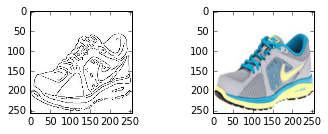

In [5]:
#Load in edge images [0,255]
edge_data = np.load('nike_edge_data.npy')
#Normalize edge images to [-1,1]
edge_data = normalize(edge_data)
#Split edge images into training and test data 90/10
edge_data,edge_data_test = train_test_split(edge_data,test_size=0.1, random_state=SEED)

#Load in real color images [0,255]
real_data = np.load('nike_shoe_data.npy')
#Normalize real images to [-1,1]
real_data = normalize(real_data)
#Split real images into training and test data 90/10
real_data,real_data_test = train_test_split(real_data,test_size=0.1,random_state=SEED)

#Number of examples
m = edge_data.shape[0]

#Display training/test data shapes
print("edge_train shape: ",edge_data.shape)
print("edge_test shape: ",edge_data_test.shape)
print("real_train shape: ",real_data.shape)
print("real_test shape: ",real_data_test.shape)

#Display the first edge image from training set
IDX = 0
plt.subplot(221)
plt.imshow(unnormalize(edge_data[IDX]))
plt.subplot(222)
plt.imshow(unnormalize(real_data[IDX]))

In [6]:
def generator_output(g_input):
    """ 
    Creates generator network.
    Encoder ~ C64-C128-C256-C512-C512-C512-C512-C512
    U-Net Decoder ~ CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    
    Input: generator input tensor
    Output: generator model
    """
    #Encoder
    l1 = Convolution2D(64,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(g_input)
    l1 = LeakyReLU(SLOPE)(l1)

    l2 = Convolution2D(128,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l1)
    l2 = BatchNormalization(mode=MODE)(l2)
    l2 = LeakyReLU(SLOPE)(l2)
 
    l3 = Convolution2D(256,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l2)
    l3 = BatchNormalization(mode=MODE)(l3)
    l3 = LeakyReLU(SLOPE)(l3)
    
    l4 = Convolution2D(512,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l3)
    l4 = BatchNormalization(mode=MODE)(l4)
    l4 = LeakyReLU(SLOPE)(l4)
    
    l5 = Convolution2D(512,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l4)
    l5 = BatchNormalization(mode=MODE)(l5)
    l5 = LeakyReLU(SLOPE)(l5)
    
    l6 = Convolution2D(512,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l5)
    l6 = BatchNormalization(mode=MODE)(l6)
    l6 = LeakyReLU(SLOPE)(l6)
    
    l7 = Convolution2D(512,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l6)
    l7 = BatchNormalization(mode=MODE)(l7)
    l7 = LeakyReLU(SLOPE)(l7)
    
    l8 = Convolution2D(512,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l7)
    l8 = BatchNormalization(mode=MODE)(l8)
    l8 = LeakyReLU(SLOPE)(l8)

    #U-Net Decoder
    x7 = Deconvolution2D(512,*KERNEL_SIZE,output_shape=(None,2,2,512),border_mode='same',subsample=STRIDE)(l8)
    x7 = BatchNormalization(mode=MODE)(x7)
    x7 = Dropout(DROPRATE)(x7)
    x7 = Activation('relu')(x7)
    x7 = merge([x7,l7],mode='concat',concat_axis=SKIP_AXIS)

    
    x6 = Deconvolution2D(512,*KERNEL_SIZE,output_shape=(None,4,4,512),border_mode='same',subsample=STRIDE)(x7)
    x6 = BatchNormalization(mode=MODE)(x6)
    x6 = Dropout(DROPRATE)(x6)
    x6 = Activation('relu')(x6)
    x6 = merge([x6,l6],mode='concat',concat_axis=SKIP_AXIS)
    
    x5 = Deconvolution2D(512,*KERNEL_SIZE,output_shape=(None,8,8,512),border_mode='same',subsample=STRIDE)(x6)
    x5 = BatchNormalization(mode=MODE)(x5)
    x5 = Dropout(DROPRATE)(x5)
    x5 = Activation('relu')(x5)
    x5 = merge([x5,l5],mode='concat',concat_axis=SKIP_AXIS)
    
    x4 = Deconvolution2D(512,*KERNEL_SIZE,output_shape=(None,16,16,512),border_mode='same',subsample=STRIDE)(x5)
    x4 = BatchNormalization(mode=MODE)(x4)
    x4 = Dropout(DROPRATE)(x4)
    x4 = Activation('relu')(x4)
    x4 = merge([x4,l4],mode='concat',concat_axis=SKIP_AXIS)
    
    x3 = Deconvolution2D(256,*KERNEL_SIZE,output_shape=(None,32,32,256),border_mode='same',subsample=STRIDE)(x4)
    x3 = BatchNormalization(mode=MODE)(x3)
    x3 = Dropout(DROPRATE)(x3)
    x3 = Activation('relu')(x3)
    x3 = merge([x3,l3],mode='concat',concat_axis=SKIP_AXIS)

    x2 = Deconvolution2D(128,*KERNEL_SIZE,output_shape=(None,64,64,128),border_mode='same',subsample=STRIDE)(x3)
    x2 = BatchNormalization(mode=MODE)(x2)
    x2 = Dropout(DROPRATE)(x2)
    x2 = Activation('relu')(x2)
    x2 = merge([x2,l2],mode='concat',concat_axis=SKIP_AXIS)
    
    x1 = Deconvolution2D(64,*KERNEL_SIZE,output_shape=(None,128,128,64),border_mode='same',subsample=STRIDE)(x2)
    x1 = BatchNormalization(mode=MODE)(x1)
    x1 = Dropout(DROPRATE)(x1)
    x1 = Activation('relu')(x1)
    x1 = merge([x1,l1],mode='concat',concat_axis=SKIP_AXIS)
    
    x0 = Deconvolution2D(IMG_DEPTH,*KERNEL_SIZE,output_shape=(None,IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH),\
                         border_mode='same',subsample=STRIDE)(x1)
    x0 = Activation('tanh')(x0)

    return x0
    

In [7]:
def discriminator_output(d_input):
    """
    Creates discriminator network.
    70x70 PatchGAN discriminator ~ C64-C128-C256-C512
    Input: Edge and image concatenated: (IMG_HEIGHT,IMG_WIDTH,2*IMG_DEPTH)
    """
    #
    l1 = Convolution2D(64,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(d_input)
    l1 = LeakyReLU(SLOPE)(l1)
    
    l2 = Convolution2D(128,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l1)
    l2 = BatchNormalization(mode=MODE)(l2)
    l2 = LeakyReLU(SLOPE)(l2)
 
    l3 = Convolution2D(256,*KERNEL_SIZE,border_mode='same',subsample=STRIDE)(l2)
    l3 = BatchNormalization(mode=MODE)(l3)
    l3 = LeakyReLU(SLOPE)(l3)
    
    l4 = Convolution2D(512,*KERNEL_SIZE,border_mode='same')(l3)
    l4 = BatchNormalization(mode=MODE)(l4)
    l4 = LeakyReLU(SLOPE)(l4)
    
    l5 = Convolution2D(1,1,1,border_mode='same')(l4)
#     l5 = Activation('sigmoid')(l5)
    return l5

In [8]:
#Custom Loss Functions
#L1 loss
def l1_loss(y_true, y_pred):
    delta = 1e-5
    return tf.multiply(delta, tf.reduce_sum(tf.abs(y_pred - y_true)))

#PatchGAN loss
def patch_loss(y_true, y_pred):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
    return 2*tf.reduce_mean(loss)

In [9]:
#Build generator network
g_input = Input(shape=(IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))
g = generator_output(g_input)
g_model = Model(input=g_input,output=g,name='generator')
adam = Adam(lr=0.0002, beta_1=0.5)
g_model.compile(optimizer = adam, loss='binary_crossentropy') #loss doesn't matter for generator
print(g_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 128, 128, 64)  3136        input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 128, 128, 64)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 64, 128)   131200      leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [10]:
#Build discriminator network
d_input = Input(shape=(IMG_HEIGHT,IMG_WIDTH,2*IMG_DEPTH))
d = discriminator_output(d_input)
d_model = Model(input=d_input,output=d,name='discriminator')
adam = Adam(lr=0.0002, beta_1=0.5)
d_model.compile(optimizer = adam, loss=patch_loss)
print(d_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 6)   0                                            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 128, 128, 64)  6208        input_2[0][0]                    
____________________________________________________________________________________________________
leakyrelu_9 (LeakyReLU)          (None, 128, 128, 64)  0           convolution2d_9[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 64, 64, 128)   131200      leakyrelu_9[0][0]                
___________________________________________________________________________________________

In [11]:
#Build gan
d_model.trainable = False
generated_img = g_model(g_input)
d_input_pair = merge([g_input,generated_img],mode='concat',concat_axis=3)

gan_output = d_model(d_input_pair)
gan = Model(input=g_input,output=[generated_img,gan_output],name='gan')
gan.compile(optimizer = adam, loss=[l1_loss,patch_loss])
print(gan.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
generator (Model)                (None, 256, 256, 3)   54431363    input_1[0][0]                    
____________________________________________________________________________________________________
merge_8 (Merge)                  (None, 256, 256, 6)   0           input_1[0][0]                    
                                                                   generator[1][0]                  
____________________________________________________________________________________________________
discriminator (Model)            (None, 32, 32, 1)     2763713     merge_8[0][0]           

In [ ]:
#Load in weights if not training from scratch
g_model.load_weights('params_generator_weights_11.hdf5',True)
d_model.load_weights('params_discriminator_weights_11.hdf5',True)

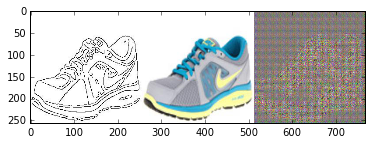

In [12]:
#Initial edge input to generator
IDX = 0
edge_data_batch = edge_data[IDX:BATCH_SIZE+IDX,:,:,:]
gg = g_model.predict(edge_data_batch)

comb = np.concatenate([edge_data_batch[0],real_data[IDX:BATCH_SIZE+IDX,:,:,:][0]],axis=1)
comb = np.concatenate([comb,gg[0]],axis=1)
plt.imshow(unnormalize(comb))
scipy.misc.imsave('nike_initial.jpg',unnormalize(comb))
# plt.subplot(221)
# plt.imshow(unnormalize(edge_data_batch[0]))
# plt.subplot(222)
# plt.imshow(unnormalize(gg[0]))

In [ ]:
#Try to train discriminator - one epoch
for i in range(m):
    edge_data_batch = edge_data[i:BATCH_SIZE+i,:,:,:]
    real_data_batch = real_data[i:BATCH_SIZE+i,:,:,:]
    fake_data_batch = g_model.predict(edge_data_batch)
#     print(edge_data_batch.shape)
#     print(real_data_batch.shape)

    #Does it matter which one goes first? (edge,img), (img,edge)?
    real_edge_pair_batch = np.concatenate((edge_data_batch,real_data_batch),axis=-1)
    fake_edge_pair_batch = np.concatenate((edge_data_batch,fake_data_batch),axis=-1)
    # img_pair_batch = np.concatenate((real_edge_pair_batch,fake_edge_pair_batch),axis=0)
#     print(real_edge_pair_batch.shape)
#     print(fake_edge_pair_batch.shape)

    #Training discriminator
    y_real = np.array([[[[1]] * 32] *32]* BATCH_SIZE)
    d_model.train_on_batch(real_edge_pair_batch,y_real)

    y_fake = np.array([[[[0]] * 32] *32]* BATCH_SIZE)
    d_loss = d_model.train_on_batch(fake_edge_pair_batch,y_fake)
    print("Step %d | D Loss: %f"% (i,d_loss))

In [ ]:
lossD = []
lossG = []
#Loop through all epochs
for e in range(NUM_EPOCHS):
    for i in range(m):
#         print(i)
        #TODO: right now just hardcode and use batch size of 1
        #Get edge and real image batches
        edge_data_batch = edge_data[i:BATCH_SIZE+i,:,:,:]
        real_data_batch = real_data[i:BATCH_SIZE+i,:,:,:]
        
        #Train discriminator
        #Generate image using edges
        fake_data_batch = g_model.predict(edge_data_batch)
        
        #Create (edge,real) data pair
        real_edge_pair_batch = np.concatenate((edge_data_batch,real_data_batch),axis=-1)
        y_real = np.array([[[[1]] * 32] *32]* BATCH_SIZE)
        d_loss = d_model.train_on_batch(real_edge_pair_batch,y_real)
#         print("Dloss ",d_loss)
        
        fake_edge_pair_batch = np.concatenate((edge_data_batch,fake_data_batch),axis=-1) 
        y_fake = np.array([[[[0]] * 32] *32]* BATCH_SIZE)
        d_model.train_on_batch(fake_edge_pair_batch,y_fake)
        
        
        #Train generator
        y_real = np.array([[[[1]] * 32] *32]* BATCH_SIZE)
#         g_loss = gan.train_on_batch(edge_data_batch, [edge_data_batch,y_real])
        g_loss = gan.train_on_batch(edge_data_batch, [real_data_batch,y_real])
    
#         lossD.append(d_loss)
#         lossG.append(g_loss[0])
        print("Epoch %d Step %d | D Loss: %f G Loss (Total): %f"% (e,i,d_loss,g_loss[0]))
        if(i%5): #TODO: this is actually updating every step lolgg -- maybe save pics to folder instead
            IDX = 3
            edge_data_batch = edge_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
            real_data_batch = real_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
            fake_data_batch = g_model.predict(edge_data_batch)
            
            comb = np.concatenate([edge_data_batch[0],real_data_batch[0]],axis=1)
            comb = np.concatenate([comb,fake_data_batch[0]],axis=1)
            plt.imshow(unnormalize(comb))
#             plt.subplot(221)
#             plt.imshow(unnormalize(fake_data_batch[0]))
#             plt.subplot(222)
#             plt.imshow(unnormalize(real_data_batch[0]))
            display.display(plt.gcf())
            display.clear_output(wait=True)
#             time.sleep(1)#TODO: does this need to be 2 seconds? can it be shorter?
        
    # save weights every epoch
    g_model.save_weights('params_generator_weights_11.hdf5', True)
    d_model.save_weights('params_discriminator_weights_11.hdf5', True)       
    
    
    

In [ ]:
# g_model.load_weights('params_generator_weights_6.hdf5',True)
IDX = 0 #Test image IDX (ie. 3)
edge_data_batch = edge_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
real_data_batch = real_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
fake_data_batch = g_model.predict(edge_data_batch)
# fake_data_batch = ((fake_data_batch+1)/2)*255
plt.imshow(unnormalize(fake_data_batch[0]))


In [ ]:
# g_model.load_weights('params_generator_weights_6.hdf5',True)
IDX = 50 #Test image IDX (ie. 3)
edge_data_batch = edge_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
real_data_batch = real_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
fake_data_batch = g_model.predict(edge_data_batch)
# fake_data_batch = ((fake_data_batch+1)/2)*255
plt.imshow(unnormalize(fake_data_batch[0]))

In [ ]:
# g_model.load_weights('params_generator_weights_6.hdf5',True)
#FIRE 2
IDX =29#Test image IDX (ie. 3)
edge_data_batch = edge_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
real_data_batch = real_data_test[IDX:BATCH_SIZE+IDX,:,:,:]
fake_data_batch = g_model.predict(edge_data_batch)
# fake_data_batch = ((fake_data_batch+1)/2)*255
plt.imshow(unnormalize(fake_data_batch[0]))

In [ ]:
plt.imshow(unnormalize(real_data_batch[0]))

In [ ]:
plt.plot(lossD)

In [ ]:
plt.plot(lossG)

In [ ]:
# save weights every epoch
g_model.save_weights('params_generator_weights_nikelogogud.hdf5', True)
d_model.save_weights('params_discriminator_weights_nikelogogud.hdf5', True)

In [ ]:
#Output all test image results
#Load in weights 
g_model.load_weights('params_generator_weights_11.hdf5',True)
d_model.load_weights('params_discriminator_weights_11.hdf5',True)
out_dir = 'out_112/'

for i in range(edge_data_test.shape[0]):
    print(i)
    edge_data_batch = edge_data_test[i:BATCH_SIZE+i,:,:,:]
    real_data_batch = real_data_test[i:BATCH_SIZE+i,:,:,:]
    fake_data_batch = g_model.predict(edge_data_batch)

    comb = np.concatenate([edge_data_batch[0],real_data_batch[0]],axis=1)
    comb = np.concatenate([comb,fake_data_batch[0]],axis=1)
    scipy.misc.imsave(out_dir+str(i)+'.jpg',unnormalize(comb))
